# decode some test sentences

save as a csv file for reading

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.preprocessing import sequence
from keras.models import Model, Sequential, model_from_json
from keras.models import load_model
from keras.layers.wrappers import Bidirectional
from keras.layers import Activation, Merge, average, concatenate, Input, TimeDistributed, LSTM, Dense, Dropout, Embedding
from keras.models import save_model, load_model
from keras_contrib.layers import CRF
from keras_contrib.utils import save_load_utils

Using TensorFlow backend.


In [2]:
# load data
print("loading data...\n")
word2idx = np.load('encoded/word2idx.npy').item()
idx2word = np.load('encoded/idx2word.npy').item()
pos2idx = np.load('encoded/pos2idx.npy').item()
idx2pos = np.load('encoded/idx2pos.npy').item()
ner2idx = np.load('encoded/ner2idx.npy').item()
idx2ner = np.load('encoded/idx2ner.npy').item()
test_idx = np.load('encoded/test_idx.npy')
X_test_sents = np.load('encoded/X_test_sents.npy')
X_test_pos = np.load('encoded/X_test_pos.npy')
y_test_ner = np.load('encoded/y_test_ner.npy')
print("...data loaded!")

loading data...

...data loaded!


## load weights

load it this way because of `keras-contrib` CRF layer

In [3]:
# params
MAX_LENGTH = 16
MAX_VOCAB = 25000    # see preprocessing.ipynb
EMBEDDING_SIZE = 100 # from default gensim model, see preprocessing.ipynb
HIDDEN_SIZE = 200    # LSTM Nodes/Features/Dimension
BATCH_SIZE = 16
DROPOUTRATE = 0.2
MAX_EPOCHS = 5       # max iterations, early stop condition below
TAG_VOCAB = len(list(idx2pos.keys()))
NER_VOCAB = len(list(idx2ner.keys()))

print('Building model...\n')

# text layers : dense embedding > dropout > bi-LSTM
txt_input = Input(shape=(MAX_LENGTH,), name='txt_input')
txt_embed = Embedding(MAX_VOCAB, EMBEDDING_SIZE, input_length=MAX_LENGTH,
                      # weights=[word_embedding_matrix],
                      name='txt_embedding', trainable=True)(txt_input)
txt_drpot = Dropout(DROPOUTRATE, name='txt_dropout')(txt_embed)
txt_lstml = Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True),
                          name='txt_bidirectional')(txt_drpot)

# pos layers : dense embedding > dropout > bi-LSTM
pos_input = Input(shape=(MAX_LENGTH,), name='pos_input')
pos_embed = Embedding(TAG_VOCAB, EMBEDDING_SIZE, input_length=MAX_LENGTH,
                      # weights=[pos_embedding_matrix],
                      name='pos_embedding', trainable=True)(pos_input)
pos_drpot = Dropout(DROPOUTRATE, name='pos_dropout')(pos_embed)
pos_lstml = Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True),
                          name='pos_bidirectional')(pos_drpot)

# merged layers : merge (concat, average...) word and pos > bi-LSTM > bi-LSTM
# mrg_cncat = average([txt_lstml, pos_lstml])
mrg_cncat = concatenate([txt_lstml, pos_lstml], axis=2)
mrg_lstml = Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True),
                          name='mrg_bidirectional_1')(mrg_cncat)
# mrg_drpot = Dropout(DROPOUTRATE, name='mrg_dropout')(mrg_lstml)
# mrg_lstml = Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True),
#                           name='mrg_bidirectional_2')(mrg_lstml)
# mrg_outpt = Activation('sigmoid', name='mrg_activation')(mrg_lstml)

# final linear chain CRF layer
crf = CRF(NER_VOCAB, sparse_target=True)
mrg_chain = crf(mrg_lstml)

model = Model(inputs=[txt_input, pos_input], outputs=mrg_chain)

Building model...



In [4]:
# load model
save_load_utils.load_all_weights(model,'model/crf_model.h5')
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
txt_input (InputLayer)           (None, 16)            0                                            
____________________________________________________________________________________________________
pos_input (InputLayer)           (None, 16)            0                                            
____________________________________________________________________________________________________
txt_embedding (Embedding)        (None, 16, 100)       2500000     txt_input[0][0]                  
____________________________________________________________________________________________________
pos_embedding (Embedding)        (None, 16, 100)       4400        pos_input[0][0]                  
___________________________________________________________________________________________

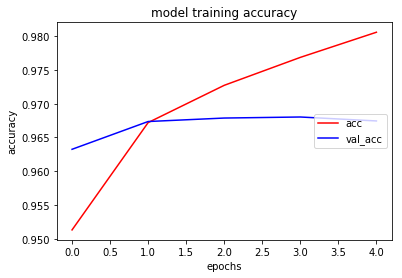

In [5]:
# load history dict from training
hist_dict = np.load('model/hist_dict.npy').item()
plt.plot(hist_dict['acc'], 'red', label='acc')
plt.plot(hist_dict['val_acc'], 'blue', label='val_acc')
plt.title("model training accuracy")
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(loc=7)
plt.show()

In [12]:
decoded = []
for sent_idx in range(len(X_test_sents[:500])):
    
    this_txt = sequence.pad_sequences([X_test_sents[sent_idx]], maxlen=MAX_LENGTH, truncating='post', padding='post')
    this_pos = sequence.pad_sequences([X_test_pos[sent_idx]], maxlen=MAX_LENGTH, truncating='post', padding='post')
    this_pred = model.predict([this_txt, this_pos])
    this_pred = [np.argmax(p) for p in this_pred[0]]
    np.shape(this_pred)

    word, pos, tru, prd = [], [], [], []

    # for each word in the sentence...
    for idx, wordid in enumerate(X_test_sents[sent_idx][:len(this_pred)]):

        # decode word
        word.append(idx2word[wordid])
        # decode pos
        pos.append(idx2pos[X_test_pos[sent_idx][idx]])
        # decode true NER tag
        tru.append(idx2ner[y_test_ner[sent_idx][idx]])
        # decode prediction
        prd.append(idx2ner[this_pred[idx]])

    answ = pd.DataFrame(
    {
        'word': word,
        'pos': pos,
        'true': tru,
        'pred': prd,
        'skip' : [' ' for s in word]
    })
    answ = answ[['word', 'pos', 'true', 'pred', 'skip']]
    answ = answ.T
    decoded.append(answ)

In [13]:
result = pd.concat(decoded)

In [16]:
result.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
word,the,u.s.,military,says,the,chinook,aircraft,went,down,early,sunday,in,zabul,province,shortly,after
pos,DT,NNP,NN,VBZ,DT,NNP,NN,VBD,RB,RB,NNP,IN,NNP,NN,RB,IN
true,O,B-geo,O,O,O,O,O,O,O,O,B-tim,O,B-geo,O,O,O
pred,O,B-geo,O,O,O,O,O,O,O,O,B-tim,O,B-geo,O,O,O
skip,,,,,,,,,,,,,,,,


In [17]:
result.to_csv('results/keras-biLSTM-CRF_sample.csv')